# Quantum PageRank with Arbitrary Phase Rotations

In this notebook we will show an example of how to calculate the quantum PageRank of a sample network using SQUWALS [[1]](Simulator), our simulator of Szegedy's quantum walks.

**It is recommended to see first the SQUWALS tutorial notebook.**

## Table of Contents

- [Packages](#0)
- [1 - Graph Model and Google Matrix](#1)
- [2 - Classical PageRank](#2)
- [3 - Quantum PageRank with SQUWALS](#3)
    - [3.1 - Original Quantum PageRank](#3-1)
    - [3.2 - Quantum PageRank with Arbitrary Phase Rotations](#3-2)
- [4 - Quantum PageRank with our high-level application](#4)
- [5 - Conclusions](#5)
- [6 - References](#6)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator.

In [1]:
import numpy as np
import squwals as sw
import matplotlib.pyplot as plt

<a name='1'></a>
## 1 - Graph Model and Google Matrix

The network that we are going to use is shown in the figure generated by the following cell.

<!--
<img src="./small_graph.png" style="width:400px;height:300px;">
-->

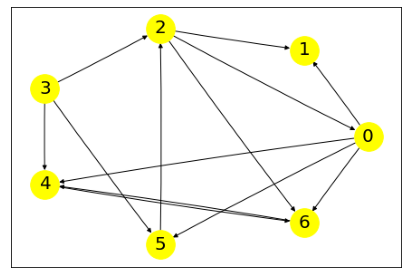

In [2]:
# Run the following cell to display the image.
fig = plt.figure(figsize=(7,7)); img = plt.imread("Figures/small_graph.png"); plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()

In order to obtain the PageRank distribution, we need to construct the matrix $H$ of the graph, defined as

$$
H_{i,j} := 
	\left\lbrace\begin{array}{c}
		1/\text{outdeg}(P_j) \ \ \ \text{if} \ P_j \in B_i,\\
		0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{otherwise},
	\end{array}
	\right.
$$

where $P_j$ refers to node $j$, and $B_i$ is the set of nodes pointing to node $i$.

In [3]:
N = 7  # Size of the graph.

H = np.array([[0, 0, 1, 0, 0, 0, 0],
              [1, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 1, 0, 0, 1],
              [1, 0, 0, 1, 0, 0, 0],
              [1, 0, 1, 0, 1, 0, 0]]).astype('float')

sums = sum(H)
for k in range(N):
    if sums[k] != 0:
        H[:,k] /= sums[k]

H

array([[0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.25      , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ,
        1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.25      , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 1.        ],
       [0.25      , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        ],
       [0.25      , 0.        , 0.33333333, 0.        , 1.        ,
        0.        , 0.        ]])

This matrix must be patched filling the null columns with $1/N$, resulting in the matrix $E$. In this case, we will fill the second column.

In [4]:
E = H.copy()
E[:,1] = 1/N

E

array([[0.        , 0.14285714, 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.25      , 0.14285714, 0.33333333, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.14285714, 0.        , 0.33333333, 0.        ,
        1.        , 0.        ],
       [0.        , 0.14285714, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.25      , 0.14285714, 0.        , 0.33333333, 0.        ,
        0.        , 1.        ],
       [0.25      , 0.14285714, 0.        , 0.33333333, 0.        ,
        0.        , 0.        ],
       [0.25      , 0.14285714, 0.33333333, 0.        , 1.        ,
        0.        , 0.        ]])

Finally, we build the Google matrix, defined as:

$$G = \alpha E + (1-\alpha) I,$$
where $\alpha = 0.25$, and $I$ is a matrix where all elements are $1/N$.

This Google matrix is a dense column-stochastic matrix, and is the one that will be used for the classical and quantum walks.

In [5]:
alpha = 0.85

# Build the matrix I where all elements are 1/N.
I = np.ones(N)/N

# Build the Google matrix using E and I.
G = alpha*E + (1-alpha)*I

G

array([[0.02142857, 0.14285714, 0.3047619 , 0.02142857, 0.02142857,
        0.02142857, 0.02142857],
       [0.23392857, 0.14285714, 0.3047619 , 0.02142857, 0.02142857,
        0.02142857, 0.02142857],
       [0.02142857, 0.14285714, 0.02142857, 0.3047619 , 0.02142857,
        0.87142857, 0.02142857],
       [0.02142857, 0.14285714, 0.02142857, 0.02142857, 0.02142857,
        0.02142857, 0.02142857],
       [0.23392857, 0.14285714, 0.02142857, 0.3047619 , 0.02142857,
        0.02142857, 0.87142857],
       [0.23392857, 0.14285714, 0.02142857, 0.3047619 , 0.02142857,
        0.02142857, 0.02142857],
       [0.23392857, 0.14285714, 0.3047619 , 0.02142857, 0.87142857,
        0.02142857, 0.02142857]])

<a name='2'></a>
## 2 - Classical PageRank

The classical PageRank distribution corresponds to the eigenvector of the Google matrix $G$ with eigenvalue $1$. Due to the form that $G$ is constructed, this eigenvalue is unique and a classical walk converges to it.

To obtain the PageRank distribution without diagonalizing the matrix $G$ we use the power method, so that we apply the matrix $G$ repeteadly to an initial probability distribution until it has converged. This is equivalent to performing a classical walk with $G$ as the transition matrix.

We are going to use our function `classical_walk_simulator` to perform this classical walk.

In [6]:
# Create an initial probability distribution. In this case we use the uniform one. It must be a 1D-array.
initial_distribution = np.ones(N)/N

# Use the classical simulator to perform the classical walk for 50 steps.
"""Args:
    transition_matrix: Column-stochastic transition matrix.
    time_steps: Number of steps of the classical walk.
    initial_distribution: Initial probability distribution of the walker. Default: the uniform one.
"""
classical_distributions = sw.classical_walk_simulator(transition_matrix=G,time_steps=50,initial_distribution=initial_distribution)

# We can do without the parameter initial_distribution if we are using the uniform distribution.
classical_distributions = sw.classical_walk_simulator(G,50)

# The result is a bidimensional tensor where the first dimension indicates the time step (including t=0), and the second one the node.
# The classical pagerank corresponds to the distribution at the last time step.
classical_pr = classical_distributions[-1]

We plot the probabilities of each node at each time step, observing that they converge. The last distribution corresponds to the classical PageRank of the graph.

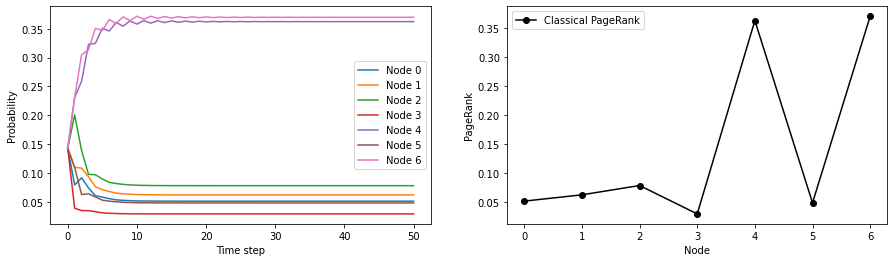

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(classical_distributions)
plt.legend([f'Node {n}' for n in range(N)])
plt.xlabel('Time step')
plt.ylabel('Probability')

plt.subplot(1,2,2)
plt.plot(classical_pr,'-ok')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.legend(['Classical PageRank'])

plt.show()

<a name='3'></a>
## 3 - Quantum PageRank with SQUWALS

In this section we show how to use our `quantum_szegedy_simulator` to obtain the quantum PageRank [[2]](https://www.nature.com/articles/srep00444) of the graph. However, our library has an specific high-level application for this algorithm, which is shown in [4 - Quantum PageRank with our high-level application](#4).

The unitary operator used for the quantum PageRank is

\begin{equation}
	U := SRSR,
\end{equation}

The initial state of the system is chosen to be:

\begin{equation}
	\left|\Psi^{(0)}\right> = \frac{1}{\sqrt{N}}\sum_{i=0}^{N-1}\left|\psi_i\right>,
\end{equation}

The position of the walker after the quantum evolution is described by the register $2$ of the quantum state, so the projection onto the computational basis of the second register will give us the quantum PageRanks for each node:

\begin{equation}\label{InstPR}
	I_q(P_i,t) := ||_2{\left<i\right|U^t\left|\Psi^{0}\right>}{}||^2.
\end{equation}

where $P_i$ is a concrete node, and $t$ the time step. This quantum PageRank depending on time is called the instantaneous quantum PageRank, and it fluctuates in time instead of converging. For that reason, it is defined the time-averaged quantum PageRank as:

\begin{equation}\label{AvPR}
	I_q(P_i) := \frac{1}{T}\sum_{t=0}^T I_q(P_i,t).
\end{equation}

This quantity converges for a value of $T$ sufficiently large [[3]](https://www.nature.com/articles/srep02773).

<a name='3-1'></a>
### 3.1 - Original Quantum PageRank

In order to obtain the instantaneous quantum PageRanks, we apply Szegedy's quantum walk to the Google matrix.

In this case the unitary corresponds to the double Szegedy operator described in [[1]](Simulator), so that it can be obtained with the class `DoubleUnitary`.

In [8]:
# Construct the unitary from the Google matrix.
U = sw.DoubleUnitary(G)
U.info()

Double Szegedy unitary:
 1 - Reflection
 2 - Swap
 3 - Reflection
 4 - Swap


The initial state $\left|\Psi^{(0)}\right>$ is obtained with the function `create_initial_state`.

In [9]:
# Create the initial state from the Google matrix.
initial_state = sw.create_initial_state(G)

We use the function `quantum_szegedy_simulator` to perform the quantum walk.

In [10]:
# Obtain the instantaneous quantum pageranks with quantum_szegedy_simulator.
"""
Args:
    unitary: Unitary operator model.
    initial_state: Initial state or batch of states.
    time_steps: Number of steps of the quantum walk.
    measure: Register to measure.
"""
instantaneous_quantum_pagerank = sw.quantum_szegedy_simulator(unitary=U,initial_state=initial_state,time_steps=500,measure=2)

# The result is a bidimensional tensor where the first dimension indicates the time step (including t=0), and the second one the node.

# We average them in time (first dimension, axis 0) to obtain the averaged quantum PageRank.
quantum_pr = np.mean(instantaneous_quantum_pagerank,axis=0)

We plot the instantaneous PageRanks of some nodes at each time step, observing that they oscillate. The averaged distribution corresponds to the quantum PageRank of the graph.

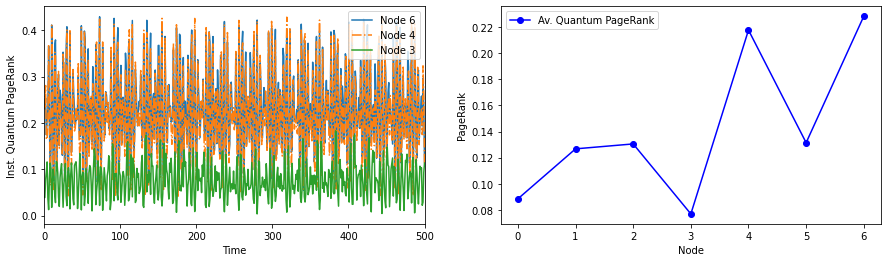

In [11]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(instantaneous_quantum_pagerank[:,6])
plt.plot(instantaneous_quantum_pagerank[:,4],'-.')
plt.plot(instantaneous_quantum_pagerank[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')

plt.subplot(1,2,2)
plt.plot(quantum_pr,'-ob')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.legend(['Av. Quantum PageRank'])

plt.show()

<a name='3-2'></a>
### 3.2 - Quantum PageRank with Arbitrary Phase Rotations

In [[4]](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013061) a generalized quantum PageRank with arbitrary phase rotations (APR) was introduced.

The unitary operator in this case is:

\begin{equation}
	U(\theta_1,\theta_2) := SR(\theta_2)SR(\theta_1),
\end{equation}
where
$$R(\theta) = \left[1-e^{i\theta}\right]\Pi - \mathbb{1}.$$

If we chose $\theta_1 = \theta_2 = \pi$, the original quantum PageRank algorithm is recovered.

Here we are going to define three APR schemes:

- Equal-Phases scheme: $\theta_1 = \theta_2 = \pi/2$.

- Opposite-Phases scheme: $\theta_1 = -\theta_2 = \pi/2$.

- Alternate-Phases scheme: $\theta_1 = \pi, \theta_2 = \pi/2$.

First, we create the operators that will form the unitaries.

In [12]:
# Swap operator.
S = sw.Swap()

# Reflection operator without phases.
R = sw.Reflection(G)

# Reflection operator with theta = pi/2.
R_plus = sw.Reflection(G,apr_phase=np.pi/2)

# Reflection operator with theta = -pi/2.
R_minus = sw.Reflection(G,apr_phase=-np.pi/2)

Now we use this building blocks to construct the unitary operators for each APR scheme. Note that when using the `Unitary` class, the first operator in the list is the first acting over the quantum state. In this case it is the reflection $R(\theta_1)$.

In [13]:
# Using the unitary class
# U_equal_phases = sw.Unitary([R_plus,S,R_plus,S])
# U_opposite_phases = sw.Unitary([R_plus,S,R_minus,S])
# U_alternate_phases = sw.Unitary([R,S,R_plus,S])

# Mutiplying operators in an algebraic sense
U_equal_phases = S * R_plus * S * R_plus
U_opposite_phases = S * R_minus * S * R_plus
U_alternate_phases = S * R_plus * S * R

Let's take a look at the information of the unitary operators.

In [14]:
U_equal_phases.info()

Custom unitary:
 1 - Reflection: apr_phase = 1.57
 2 - Swap
 3 - Reflection: apr_phase = 1.57
 4 - Swap


In [15]:
U_opposite_phases.info()

Custom unitary:
 1 - Reflection: apr_phase = 1.57
 2 - Swap
 3 - Reflection: apr_phase = -1.57
 4 - Swap


In [16]:
U_alternate_phases.info()

Custom unitary:
 1 - Reflection
 2 - Swap
 3 - Reflection: apr_phase = 1.57
 4 - Swap


Now we simulate the quantum walk as before, with the three unitaries that we have built.

In [17]:
initial_state = sw.create_initial_state(G)

# Obtain the instantaneous PageRanks.
instantaneous_equal_phases = sw.quantum_szegedy_simulator(unitary=U_equal_phases,initial_state=initial_state,time_steps=500,measure=2)
instantaneous_opposite_phases = sw.quantum_szegedy_simulator(unitary=U_opposite_phases,initial_state=initial_state,time_steps=500,measure=2)
instantaneous_alternate_phases = sw.quantum_szegedy_simulator(unitary=U_alternate_phases,initial_state=initial_state,time_steps=500,measure=2)

# Average them in time.
quantum_pr_equal_phases = np.mean(instantaneous_equal_phases,axis=0)
quantum_pr_opposite_phases = np.mean(instantaneous_opposite_phases,axis=0)
quantum_pr_alternate_phases = np.mean(instantaneous_alternate_phases,axis=0)

We plot the instantaneous PageRanks of some nodes, and the averaged quantum PageRanks.

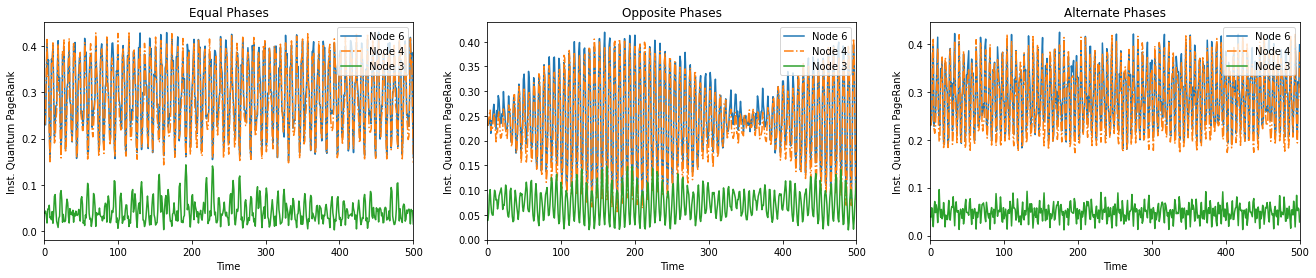

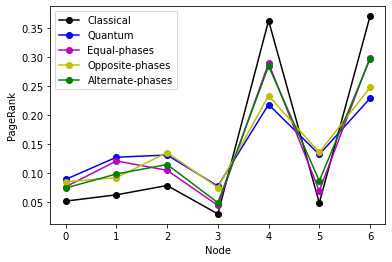

In [18]:
plt.figure(figsize=(22.5,4))

plt.subplot(1,3,1)
plt.plot(instantaneous_equal_phases[:,6])
plt.plot(instantaneous_equal_phases[:,4],'-.')
plt.plot(instantaneous_equal_phases[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Equal Phases')

plt.subplot(1,3,2)
plt.plot(instantaneous_opposite_phases[:,6])
plt.plot(instantaneous_opposite_phases[:,4],'-.')
plt.plot(instantaneous_opposite_phases[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Opposite Phases')

plt.subplot(1,3,3)
plt.plot(instantaneous_alternate_phases[:,6])
plt.plot(instantaneous_alternate_phases[:,4],'-.')
plt.plot(instantaneous_alternate_phases[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Alternate Phases')

plt.show()


plt.plot(classical_pr,'-ok')
plt.plot(quantum_pr,'-ob')
plt.plot(quantum_pr_equal_phases,'-om')
plt.plot(quantum_pr_opposite_phases,'-oy')
plt.plot(quantum_pr_alternate_phases,'-og')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.legend(['Classical','Quantum','Equal-phases','Opposite-phases','Alternate-phases'])
plt.show()

<a name='4'></a>
## 4 - Quantum PageRank with our high-level application

In this section we show our function `quantum_pagerank` to obtain directly the quantum PageRanks without having to build the unitary operators.

In [19]:
# Apply our function to the Google matrix.

"""
Args:
    google_matrix: Google matrix.
    time_steps: Number of steps of the classical walk.
    apr_phase_1: Arbitrary phase rotation of the first reflection (optional).
    apr_phase_2: Arbitrary phase rotation of the second reflection (optional).
"""

results_quantum = sw.quantum_pagerank(G,500)
results_equal_phases = sw.quantum_pagerank(G,500,np.pi/2,np.pi/2)
results_opposite_phases = sw.quantum_pagerank(G,500,np.pi/2,-np.pi/2)
results_alternate_phases = sw.quantum_pagerank(G,500,np.pi,np.pi/2)

# The result is an object with three attributes.

"""
Attributes:
    instantaneous: Instantaneous quantum pageranks.
    averaged: Averaged quantum pageranks.
    std: Standard deviation of the averaged quantum pageranks.
"""

# Retrieve the averaged quantum PageRanks.
quantum_pr = results_quantum.averaged
quantum_pr_equal_phases = results_equal_phases.averaged
quantum_pr_opposite_phases = results_opposite_phases.averaged
quantum_pr_alternate_phases = results_alternate_phases.averaged

# Retrieve the instantaneous quantum PageRanks.
instantaneous_quantum = results_quantum.instantaneous
instantaneous_equal_phases = results_equal_phases.instantaneous
instantaneous_opposite_phases = results_opposite_phases.instantaneous
instantaneous_alternate_phases = results_alternate_phases.instantaneous

# Retrieve the standard deviations of the quantum PageRanks.
std_quantum = results_quantum.std
std_equal_phases = results_equal_phases.std
std_opposite_phases = results_opposite_phases.std
std_alternate_phases = results_alternate_phases.std

Usually we are only interested in the averaged quantum PageRanks. In that case, the code below is shorter.

In [20]:
quantum_pr = sw.quantum_pagerank(G,500).averaged
quantum_pr_equal_phases = sw.quantum_pagerank(G,500,np.pi/2,np.pi/2).averaged
quantum_pr_opposite_phases = sw.quantum_pagerank(G,500,np.pi/2,-np.pi/2).averaged
quantum_pr_alternate_phases = sw.quantum_pagerank(G,500,np.pi,np.pi/2).averaged

We plot the instantaneous PageRanks of some nodes.

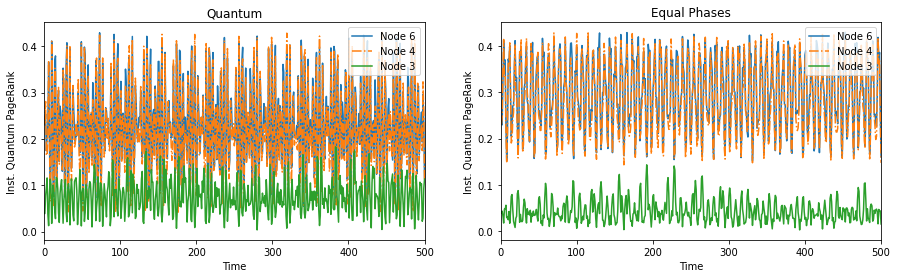

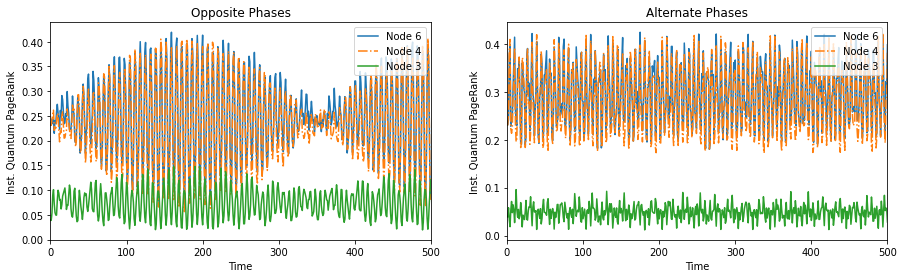

In [21]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(instantaneous_quantum[:,6])
plt.plot(instantaneous_quantum[:,4],'-.')
plt.plot(instantaneous_quantum[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Quantum')

plt.subplot(1,2,2)
plt.plot(instantaneous_equal_phases[:,6])
plt.plot(instantaneous_equal_phases[:,4],'-.')
plt.plot(instantaneous_equal_phases[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Equal Phases')
plt.show()

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(instantaneous_opposite_phases[:,6])
plt.plot(instantaneous_opposite_phases[:,4],'-.')
plt.plot(instantaneous_opposite_phases[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Opposite Phases')

plt.subplot(1,2,2)
plt.plot(instantaneous_alternate_phases[:,6])
plt.plot(instantaneous_alternate_phases[:,4],'-.')
plt.plot(instantaneous_alternate_phases[:,3])
plt.legend(['Node 6','Node 4', 'Node 3'],loc=1)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Inst. Quantum PageRank')
plt.title('Alternate Phases')
plt.show()

We plot the averaged quantum PageRanks and their standard deviations.

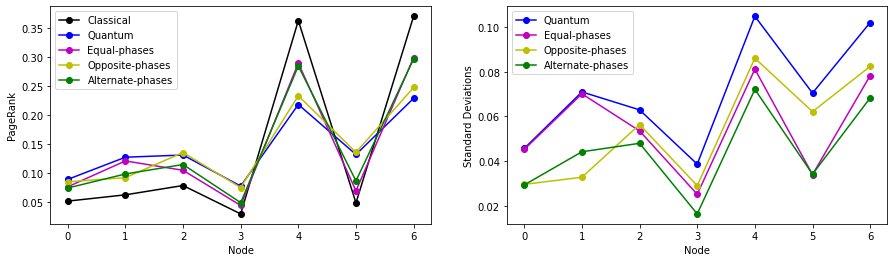

In [22]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(classical_pr,'-ok')
plt.plot(quantum_pr,'-ob')
plt.plot(quantum_pr_equal_phases,'-om')
plt.plot(quantum_pr_opposite_phases,'-oy')
plt.plot(quantum_pr_alternate_phases,'-og')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.legend(['Classical','Quantum','Equal-phases','Opposite-phases','Alternate-phases'])
# plt.show()

plt.subplot(1,2,2)
plt.plot(std_quantum,'-ob')
plt.plot(std_equal_phases,'-om')
plt.plot(std_opposite_phases,'-oy')
plt.plot(std_alternate_phases,'-og')
plt.xlabel('Node')
plt.ylabel('Standard Deviations')
plt.legend(['Quantum','Equal-phases','Opposite-phases','Alternate-phases'])
plt.show()

<a name='5'></a>
## 5 - Conclusions

We have seen how to obtain the Google matrix from a graph. We have used it to simulate the classical PageRank using our classical walk simulator.

To obtain the quantum PageRank, we have seen two methods. One using our Szegedy's quantum walk simulator, and other using our specific application for the quantum PageRank. Moreover, we have introduced arbitrary phase rotations to the algorithm.

<a name='6'></a>
## 6 - References

- [1] **[Simulator](...)**
- [2] **[Google in a Quantum Network - Giuseppe D. Paparo, M. A. Martin-Delgado](https://www.nature.com/articles/srep00444)**
- [3] **[Quantum Google in a Complex Network - Giuseppe D. Paparo, Markus Müller, Francesc Comellas, Miguel A. Martin-Delgado](https://www.nature.com/articles/srep02773)**
- [4] **[Generalized quantum PageRank algorithm with arbitrary phase rotations - Sergio A. Ortega, Miguel A. Martin-Delgado](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013061)**